# Analyzing [Stack Overflow Annual Developer Surveys](https://insights.stackoverflow.com/survey).

In [20]:
import pandas as pd

In [21]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999

In [22]:
surveys = {
    "2011": {
        "data": "2011 Stack Overflow Survey Results/2011 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2012": {
        "data": "2012 Stack Overflow Survey Results/2012 Stack Overflow Survey Results.csv",
        "readme": None,
        "schema": None
    },
    "2013": {
        "data": "2013 Stack Overflow Survey Responses/2013 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2014": {
        "data": "2014 Stack Overflow Survey Responses/2014 Stack Overflow Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2015": {
        "data": "2015 Stack Overflow Developer Survey Responses/2015 Stack Overflow Developer Survey Responses.csv",
        "readme": None,
        "schema": None
    },
    "2016": {
        "data": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv",
        "readme": "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Results/READ_ME_-_The_Public_2016_Stack_Overflow_Developer_Survey_Results.txt",
        "schema": None
    },
    "2017": {
        "data": "developer_survey_2017/survey_results_public.csv",
        "readme": "developer_survey_2017/README_2017.txt",
        "schema": "developer_survey_2017/survey_results_schema.csv"
    },
    "2018": {
        "data": "developer_survey_2018/survey_results_public.csv",
        "readme": "developer_survey_2018/README_2018.txt",
        "schema": "developer_survey_2018/survey_results_schema.csv"
    },
    "2019": {
        "data": "developer_survey_2019/survey_results_public.csv",
        "readme": "developer_survey_2019/README_2019.txt",
        "schema": "developer_survey_2019/survey_results_schema.csv"
    },
    "2020": {
        "data": "developer_survey_2020/survey_results_public.csv",
        "readme": "developer_survey_2020/README_2020.txt",
        "schema": "developer_survey_2020/survey_results_schema.csv"
    }
}

In [23]:
mapping = {
    "What Country or Region do you live in?": "Country",
    "How old are you?": "Age",
    "age_midpoint": "Age",
    "How many years of IT/Programming experience do you have?": "YearsCode",
    "Which best describes the size of your company?": "OrgSize",
    "How many developers are employed at your company?": "OrgSize",
    "company_size_range": "OrgSize",
    "Which of the following best describes your occupation?": "Employment",
    "What type of project are you developing?": "DevType",
    "Including bonus, what is your annual compensation in USD?": "ConvertedComp"
}

In [24]:
def search_schema(df, string):
    """Searches schema's DataFrame columns 'Question' for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        DataFrame containing labels and questions with the matched word.
    """
    if 'Question' in df.columns:
        return df[df['Question'].str.contains('\W*'+string+'\W*', case=False, regex=True)]
    return df[df['QuestionText'].str.contains('\W*'+string+'\W*', case=False, regex=True)]

def search_columns(df, string):
    """Searches DataFrame's columns for the word match.
    Args:
        df (pandas.DataFrame):
        string (str):
    Returns:
        List containing all the columns with the word match.
    """
    return df.columns[df.columns.str.contains('\W*'+string+'\W*', case=False, regex=True)].tolist()

In [25]:
survey_2011 = pd.read_csv(surveys['2011']['data'])
survey_2011.head()

,What Country or Region do you live in?,Which US State or Territory do you live in?,How old are you?,How many years of IT/Programming experience do you have?,How would you best describe the industry you work in?,Which best describes the size of your company?,Which of the following best describes your occupation?,How likely is it that a recommendation you make will be acted upon?,What is your involvement in purchasing? You can choose more than 1.,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,"In the last 12 months, how much money have you spent on personal technology-related purchases?",Which of our sites do you frequent most?
0,Response,Response,Response,Response,Response,Response,Response,Response,Influencer,Recommender,...,AppleTV,iPad,Other netbook,PS3,Xbox,Wii,Other gaming system,other (please specify),Response,Response
1,Africa,NaN,< 20,<2,Consulting,Start Up (1-25),Web Application Developer,Not in a million years,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<$100,NaN
2,Other Europe,NaN,25-29,41310,Software Products,Mature Small Business (25-100),Server Programmer,It's been known to happen,NaN,NaN,...,NaN,NaN,Other netbook,NaN,NaN,NaN,NaN,NaN,$251-$500,Stack Overflow
3,India,NaN,25-29,41435,Software Products,Mid Sized (100-999),Server Programmer,Unless it's stoopid it gets done,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Germany,NaN,< 20,41310,Foundation / Non-Profit,Student,Student,It's been known to happen,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Wii,Other gaming system,NaN,"$501-$1,000",Stack Overflow


In [26]:
survey_2011.columns.tolist()

['What Country or Region do you live in?',
 'Which US State or Territory do you live in?',
 'How old are you?',
 'How many years of IT/Programming experience do you have?',
 'How would you best describe the industry you work in?',
 'Which best describes the size of your company?',
 'Which of the following best describes your occupation?',
 'How likely is it that a recommendation you make will be acted upon?',
 'What is your involvement in purchasing? You can choose more than 1.',
 'Unnamed: 9',
 'Unnamed: 10',
 'Unnamed: 11',
 'Unnamed: 12',
 'Unnamed: 13',
 'Unnamed: 14',
 'What types of purchases are you involved in?',
 'Unnamed: 16',
 'Unnamed: 17',
 'Unnamed: 18',
 'Unnamed: 19',
 'Unnamed: 20',
 'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2011?',
 'Unnamed: 22',
 'Unnamed: 23',
 'Unnamed: 24',
 'Unnamed: 25',
 'Unnamed: 26',
 'Unnamed: 27',
 'Unnamed: 28',
 'What type of project are you developing?',
 'Which languages are you proficient 

In [27]:
survey_2011['What Country or Region do you live in?'].value_counts()

United States of America    1037
Other Europe                 451
United Kingdom               314
Canada                       156
Australia                    112
Germany                      106
India                         95
South America                 91
Other Asia                    81
Middle East                   73
France                        60
Netherlands                   55
Africa                        43
Russia                        41
Italy                         35
Australasia                   29
Mexico                        20
North America (Other)          8
Central America                6
Response                       1
Name: What Country or Region do you live in?, dtype: int64

In [28]:
survey_2011['How many years of IT/Programming experience do you have?'].value_counts()

11          1044
41435        822
41310        717
<2           146
Response       1
Name: How many years of IT/Programming experience do you have?, dtype: int64

In [29]:
survey_2011['How would you best describe the industry you work in?'].value_counts()

Software Products          814
Web Services               495
Other                      396
Consulting                 322
Finance / Banking          189
Education                  157
Healthcare                  81
Manufacturing               77
Retail                      56
Foundation / Non-Profit     50
Gaming                      49
Advertising                 43
Response                     1
Name: How would you best describe the industry you work in?, dtype: int64

In [30]:
survey_2011['How old are you?'].value_counts()

25-29       831
30-34       612
20-24       507
35-39       343
40-50       277
< 20        116
51-60        37
>60           6
Response      1
Name: How old are you?, dtype: int64

In [31]:
survey_2011['Which best describes the size of your company?'].value_counts()

Start Up (1-25)                          745
Mature Small Business (25-100)           569
Fortune 1000 (1,000+)                    543
Mid Sized (100-999)                      447
Student                                  203
Other (not working, consultant, etc.)    139
Response                                   1
Name: Which best describes the size of your company?, dtype: int64

In [32]:
survey_2011['Which of the following best describes your occupation?'].value_counts()

Web Application Developer                1066
Desktop Application Developer             419
Server Programmer                         213
Student                                   198
Manager of Developers or Team Leader      195
Other                                     170
Embedded Application Developer            115
IT Staff / System Administrator            85
Executive (VP of Eng, CTO, CIO, etc.)      70
Systems Analyst                            54
IT Manager                                 28
Database Administrator                     23
Kernel / Driver Developer                  10
Response                                    1
Name: Which of the following best describes your occupation?, dtype: int64

In [33]:
survey_2011['Please rate your job/career satisfaction'].value_counts()

I enjoy going to work      1419
It pays the bills           585
So happy it hurts           327
I'm not happy in my job     159
FML                          63
Response                      1
Name: Please rate your job/career satisfaction, dtype: int64

In [34]:
survey_2011['Including bonus, what is your annual compensation in USD?'].value_counts()

$40,000 - $60,000       415
$60,000 - $80,000       413
$20,000 - $40,000       318
$80,000 - $100,000      292
<$20,000                283
$100,000 - $120,000     222
Student / Unemployed    215
>$140,000               110
$120,000 - $140,000      97
Response                  1
Name: Including bonus, what is your annual compensation in USD?, dtype: int64

In [35]:
survey_2011['What type of project are you developing?'].value_counts()

Web Platform    864
Enterprise      824
Other           515
SaaS            201
Mobile          194
Response          1
Name: What type of project are you developing?, dtype: int64

In [36]:
survey_2011_map = {
    "What Country or Region do you live in?",
    "How old are you?",
    "How many years of IT/Programming experience do you have?",
#     "How would you best describe the industry you work in?",
    "Which best describes the size of your company?",
    "Which of the following best describes your occupation?",
    "What type of project are you developing?",
    "Including bonus, what is your annual compensation in USD?"
}

In [37]:
survey_2011[survey_2011_features].info()

NameError: name 'survey_2011_features' is not defined

In [ ]:
survey_2012 = pd.read_csv(surveys['2012']['data'])
survey_2012[[col for col in survey_2012.columns if 'Unnamed' not in col]].info()

In [ ]:
for col in survey_2011_features:
    if col not in survey_2012.columns:
        print(col)

In [ ]:
survey_2012_features = survey_2011_features.copy()
# survey_2012_features.remove('How would you best describe the industry you work in?')
# survey_2012_features.append('How would you best describe the industry you currently work in?')

In [ ]:
survey_2012[survey_2012_features].info()

In [ ]:
for k, v in surveys.items():
    current_survey = pd.read_csv(v['data'], low_memory=False)
    exploring_columns = [col for col in current_survey.columns if 'Unnamed' not in col]
    print(f"Survey: {k}", current_survey[exploring_columns].info(), "="*50, sep="\n")

In [ ]:
survey_2017 = pd.read_csv(surveys['2017']['data'])
survey_2017.head()

In [ ]:
survey_2017_schema = pd.read_csv(surveys['2017']['schema'])
survey_2017_schema

In [ ]:
search_schema(pd.read_csv(surveys['2017']['schema']), 'age')

In [ ]:
search_schema(pd.read_csv(surveys['2020']['schema']), 'salary')

In [ ]:
survey_2020_features = {
    "Country": "Country",
    "Age": "Age",
    "YearsCode": "YearsCode",
    "OrgSize": "OrgSize",
    "Employment": "Employment",
    "DevType": "DevType",
    "ConvertedComp": "ConvertedComp"
}

In [ ]:
survey_2019 = pd.read_csv(surveys['2019']['data'])
survey_2019[survey_2020_features].info()

In [ ]:
survey_2011_map = {
    "Country": "What Country or Region do you live in?",
    "Age": "How old are you?",
    "YearsCode": "How many years of IT/Programming experience do you have?",
    "OrgSize": "Which best describes the size of your company?",
    "Employment": "Which of the following best describes your occupation?",
    "DevType": "What type of project are you developing?",
    "ConvertedComp": "Including bonus, what is your annual compensation in USD?"
}

In [ ]:
survey_2011_features

In [ ]:
survey_2020 = pd.read_csv(surveys['2020']['data'])
survey_2020['Employment'].value_counts()

In [ ]:
survey_2020['MainBranch'].value_counts()

In [ ]:
survey_2020['CompTotal'].value_counts(normalize=True, bins=10)

In [ ]:
for k, v in surveys.items():
    survey = pd.read_csv(v['data'], low_memory=True)
    print(k, "="*50, "\n")
    survey.rename(mapping, inplace=True)

In [ ]:
dfs = []
for k, v in surveys.items():
    if int(k) <= 2016:
        continue
    survey = pd.read_csv(v['data'], low_memory=True)
    survey.rename(mapping, axis=1,inplace=True)
    print(k)
    dfs.append(survey[set(mapping.values())])
df = pd.concat(dfs, keys=surveys.keys())

In [ ]:
list(set(mapping.values()))

In [ ]:
survey_2014 = pd.read_csv(surveys['2014']['data'])
survey_2015 = pd.read_csv(surveys['2015']['data'], skiprows=[0])
survey_2016 = pd.read_csv(surveys['2016']['data'])
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)
survey_2018 = pd.read_csv(surveys['2018']['data'], low_memory=True)

In [ ]:
search_columns(survey_2017, 'old')

In [ ]:
search_schema(pd.read_csv(surveys['2017']['schema'], low_memory=True), ' ')

Looks like only a few amount of questions could be analyzed in the context of time.
I abandon the main idea and now will search for fun questions in the context of salary, gender, age, country, time.

In [ ]:
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
salaries_clean = survey_2017['Salary'].dropna(axis=0)
salaries_clean = salaries_clean[salaries_clean != 0]
intervals = [i for i in range(0, 120001, 20000)] + [150000, 200000]
salaries = pd.cut(salaries_clean, intervals)

In [ ]:
salaries = pd.DataFrame(salaries)
salaries.value_counts()

In [ ]:
salaries.value_counts()

In [ ]:
salaries.value_counts(normalize=True).sort_index(ascending=True).plot(kind='barh', title='Salary distribution', xlabel='Salary range, USD', ylabel='%');

In [ ]:
plt.hist(survey_2017['Salary']);

In [ ]:
merged = pd.merge(survey_2017, salaries, how='inner', left_index=True, right_index=True)

In [ ]:
merged['Overpaid'].value_counts()

In [ ]:
intervals_adjusted = intervals[1:]
merged['Salary_x'] = merged['Salary_x'].apply(lambda x: intervals_adjusted[np.argmin(abs(np.array(intervals_adjusted) - x))])

In [ ]:
merged['Overpaid'].value_counts(normalize=True).plot(kind='barh');

In [ ]:
sorted(merged['Salary_x'].unique())

In [ ]:
merged['Overpaid'].fillna('Unknown', inplace=True)

In [18]:
salary_overpaid_2017 = merged[['Salary_x', 'Overpaid', 'Respondent']].groupby(['Salary_x', 'Overpaid']).count()
salary_overpaid_2017.fillna('NA', inplace=True)


In [ ]:
salary_overpaid_2017.loc[idx[:, overpaid], :]

In [ ]:
np.std(intervals_adjusted)

In [ ]:
idx = pd.IndexSlice
salary_overpaid_2017.loc[idx[:,'Somewhat underpaid'], :]

In [ ]:
len(intervals_adjusted) * [0] + salary_overpaid_2017.loc[(slice(None), slice('Greatly underpaid')), :].values.reshape(1,-1)

In [ ]:
merged[['Salary_x', 'Overpaid', 'Respondent']].groupby('Overpaid').count()

In [ ]:
intervals_adjusted

In [ ]:
merged.head()

In [38]:
survey_2017 = pd.read_csv(surveys['2017']['data'], low_memory=True)
survey_2017.shape

(51392, 154)

In [39]:
intervals_adjusted = [i for i in range(10000, 100001, 10000)] + [i for i in range(120000, 200001, 20000)]

def process_salary(df):
    dataframe = df.copy()
    dataframe = dataframe.dropna(subset=['Salary'], axis=0)
    dataframe['Salary'] = dataframe['Salary'].apply(lambda x: intervals_adjusted[np.argmin(abs(np.array(intervals_adjusted) - x))])
    return dataframe

def process_overpaid(df):
    dataframe = df.copy()
    dataframe['Overpaid'] = dataframe['Overpaid'].fillna('Unknown')
    return dataframe

def make_dummies(df, col, prefix):
    dataframe = pd.get_dummies(df, columns=[col], prefix=prefix)
    return dataframe

survey_2017_clean = survey_2017.copy()
survey_2017_clean = process_salary(survey_2017_clean)
survey_2017_clean = process_overpaid(survey_2017_clean)
overpaid_list = ['Overpaid_'+i for i in survey_2017_clean['Overpaid'].unique()]
survey_2017_clean = make_dummies(survey_2017_clean, 'Overpaid', 'Overpaid')

In [40]:
set(survey_2017_clean.columns).difference(set(survey_2017))

{'Overpaid_Greatly overpaid',
 'Overpaid_Greatly underpaid',
 'Overpaid_Neither underpaid nor overpaid',
 'Overpaid_Somewhat overpaid',
 'Overpaid_Somewhat underpaid',
 'Overpaid_Unknown'}

In [41]:
overpaid_dict = {
    "Overpaid_Greatly underpaid": "Greatly underpaid",
    "Overpaid_Somewhat underpaid": "Somewhat underpaid",
    "Overpaid_Neither underpaid nor overpaid": "Neither",
    "Overpaid_Somewhat overpaid": "Somewhat overpaid",
    "Overpaid_Greatly overpaid": "Greatly overpaid",
    "Overpaid_Unknown": "Not sure"
}

In [42]:
salary_overpaid_2017 = survey_2017_clean[['Salary']+overpaid_list].groupby(by='Salary').sum()
salary_overpaid_2017

,Overpaid_Neither underpaid nor overpaid,Overpaid_Somewhat underpaid,Overpaid_Somewhat overpaid,Overpaid_Greatly underpaid,Overpaid_Unknown,Overpaid_Greatly overpaid
Salary,,,,,,
10000,603.0,928.0,86.0,457.0,17.0,21.0
20000,295.0,466.0,43.0,156.0,1.0,10.0
30000,356.0,590.0,71.0,193.0,4.0,5.0
40000,481.0,678.0,66.0,163.0,1.0,8.0
50000,534.0,721.0,62.0,164.0,2.0,7.0
60000,474.0,592.0,88.0,121.0,2.0,4.0
70000,334.0,435.0,57.0,68.0,1.0,1.0
80000,285.0,334.0,43.0,44.0,1.0,7.0
90000,265.0,271.0,55.0,31.0,1.0,3.0


In [43]:
def convert_xticks(arr):
    result = map(lambda x: str(x//1000)+'k', arr)
    return list(result)

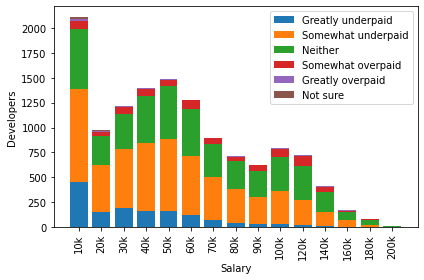

In [66]:
bottom = len(intervals_adjusted) * [0]
ticks = np.arange(len(intervals_adjusted))
labels = convert_xticks(intervals_adjusted)

for i, overpaid in enumerate(overpaid_dict):
    plt.bar(ticks, salary_overpaid_2017[overpaid].values, bottom=bottom, align='center')
    bottom += salary_overpaid_2017[overpaid].values
    
plt.legend(overpaid_dict.values())
plt.xlabel('Salary')
plt.ylabel('Developers')
plt.xticks(ticks, labels, rotation=90)
plt.tight_layout()
plt.show()

In [68]:
survey_2018 = pd.read_csv(surveys['2018']['data'], low_memory=True)
print(survey_2018.shape, survey_2018.columns.tolist())

(98855, 129) ['Respondent', 'Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation', 'UndergradMajor', 'CompanySize', 'DevType', 'YearsCoding', 'YearsCodingProf', 'JobSatisfaction', 'CareerSatisfaction', 'HopeFiveYears', 'JobSearchStatus', 'LastNewJob', 'AssessJob1', 'AssessJob2', 'AssessJob3', 'AssessJob4', 'AssessJob5', 'AssessJob6', 'AssessJob7', 'AssessJob8', 'AssessJob9', 'AssessJob10', 'AssessBenefits1', 'AssessBenefits2', 'AssessBenefits3', 'AssessBenefits4', 'AssessBenefits5', 'AssessBenefits6', 'AssessBenefits7', 'AssessBenefits8', 'AssessBenefits9', 'AssessBenefits10', 'AssessBenefits11', 'JobContactPriorities1', 'JobContactPriorities2', 'JobContactPriorities3', 'JobContactPriorities4', 'JobContactPriorities5', 'JobEmailPriorities1', 'JobEmailPriorities2', 'JobEmailPriorities3', 'JobEmailPriorities4', 'JobEmailPriorities5', 'JobEmailPriorities6', 'JobEmailPriorities7', 'UpdateCV', 'Currency', 'Salary', 'SalaryType', 'ConvertedSalary', 'CurrencySymbol', 'C

In [71]:
survey_2018['Exercise'].value_counts(dropna=False)

I don't typically exercise    26995
NaN                           26747
1 - 2 times per week          20932
3 - 4 times per week          14318
Daily or almost every day      9863
Name: Exercise, dtype: int64

In [75]:
survey_2018['Age'].value_counts(dropna=False)

NaN                   34281
25 - 34 years old     31759
18 - 24 years old     15249
35 - 44 years old     11477
45 - 54 years old      3313
Under 18 years old     1638
55 - 64 years old       959
65 years or older       179
Name: Age, dtype: int64

In [76]:
survey_2018['CompanySize'].value_counts(dropna=False)

NaN                         27324
20 to 99 employees          16996
100 to 499 employees        14011
10,000 or more employees     9757
10 to 19 employees           8007
1,000 to 4,999 employees     7634
Fewer than 10 employees      7479
500 to 999 employees         4630
5,000 to 9,999 employees     3017
Name: CompanySize, dtype: int64

In [84]:
survey_2018['HoursOutside'].value_counts(dropna=False)

1 - 2 hours             27788
NaN                     26831
30 - 59 minutes         24002
Less than 30 minutes    11223
3 - 4 hours              7186
Over 4 hours             1825
Name: HoursOutside, dtype: int64

In [85]:
survey_2018['YearsCoding'].value_counts(dropna=False)

3-5 years           23313
6-8 years           19338
9-11 years          12169
0-2 years           10682
12-14 years          8030
15-17 years          6117
18-20 years          5072
NaN                  5020
30 or more years     3544
21-23 years          2648
24-26 years          1862
27-29 years          1060
Name: YearsCoding, dtype: int64

In [106]:
from itertools import chain

survey_2018_clean = survey_2018.copy()
survey_2018_clean = survey_2018_clean.dropna(subset=['LanguageWorkedWith'], axis=0)
lang_list = survey_2018_clean['LanguageWorkedWith'].dropna().str.split(';').tolist()
lang_set = set(chain(*lang_list))

dummies = pd.get_dummies(survey_2018_clean['LanguageWorkedWith'].str.split(';').explode()).sum(level=0)
dummies.sum().sort_values(ascending=False)

JavaScript              54686
HTML                    53628
CSS                     50979
SQL                     44670
Java                    35521
Bash/Shell              31172
Python                  30359
C#                      26954
PHP                     24071
C++                     19872
C                       18042
TypeScript              13626
Ruby                     7911
Swift                    6310
Assembly                 5760
Go                       5532
Objective-C              5510
VB.NET                   5254
R                        4813
Matlab                   4564
VBA                      3810
Kotlin                   3508
Scala                    3420
Groovy                   3373
Perl                     3280
Visual Basic 6           3087
Lua                      2733
CoffeeScript             2603
Delphi/Object Pascal     2025
Haskell                  1961
Rust                     1857
F#                       1115
Clojure                  1032
Erlang    

In [92]:
search_schema(pd.read_csv(surveys['2018']['schema']), 'language')

,Column,QuestionText
20,AssessJob4,"Imagine that you are assessing a potential job opportunity. Please rank the following aspects of the job opportunity in order of importance (by dragging the choices up and down), where 1 is the most important and 10 is the least important. The languages, frameworks, and other technologies I'd be working with"
65,LanguageWorkedWith,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
66,LanguageDesireNextYear,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
92,AdsPriorities7,"Please rank the following advertising qualities in order of their importance to you (by dragging the choices up and down), where 1 is the most important, and 7 is the least important. The advertisement avoids fluffy or vague language"
